## Secure Applications

In this notebook you will: 

-   Reserve resources for this experiment
-   Configure your reserved resources
-   Access your reserved resources over SSH
-   Retrieve files saved on a FABRIC resources
-   Delete your FABRIC reservation (in case you finish early)

### Exercise: Reserve resources

In this exercise, we will reserve resources on FABRIC for the experiments on network layer security.

In [40]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,40ba6253-c257-4d9c-8658-7406bb437eb5
Bastion Username,cy2478_0000088631
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


In [41]:
!chmod 600 {fablib.get_bastion_key_filename()}
!chmod 600 {fablib.get_default_slice_private_key_file()}

In [42]:
import os
slice_name="network-security_" + os.getenv('NB_USER')

In [44]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named network-security_cy2478 yet.
Continue to the next step to make one.


Next, we’ll select a random FABRIC site for our experiment. We’ll make sure to get one that has sufficient capacity for the experiment we’re going to run.

Once we find a suitable site, we’ll print details about available resources at this site.

In [45]:
exp_requires = {'core': 3*2, 'nic': 4}
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_requires['core']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_requires['nic']) ):
        break

fablib.show_site(site_name)

Name,NCSA
State,Active
Address,"1725 S Oak St.,Champaign, IL 61820"
Location,"(40.1035624, -88.2415105)"
Hosts,3
CPUs,6
Cores Available,158
Cores Capacity,192
Cores Allocated,34
RAM Available,1416
RAM Capacity,1536


'<pandas.io.formats.style.Styler object at 0x7f816808f190>'

In [46]:
# this cell sets up the nodes
node_names = ["romeo", "juliet", "server", "router-int", "router-ext", "vpn"]
for n in node_names:
    slice.add_node(name=n, site=site_name, cores=2, ram=4, disk=10, image='default_ubuntu_22')

In [47]:
# this cell sets up the network links
nets = [
    {"name": "net0",   "nodes": ["romeo", "router-int"]},
    {"name": "net1",  "nodes": ["server", "router-int"]},
    {"name": "net2",  "nodes": ["router-int", "vpn"]},
    {"name": "net3",  "nodes": ["vpn", "router-ext"]},
    {"name": "net4",  "nodes": ["router-ext", "juliet"]}
]
for n in nets:
    ifaces = [slice.get_node(node).add_component(model="NIC_Basic", name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

While it is being prepared, the “State” of the slice will appear as “Configuring”.
When it is ready, the “State” of the slice will change to “StableOK”.

In [48]:
slice.submit()


Retry: 9, Time: 457 sec


ID,093564d2-d246-474d-a078-4c558d4f1928
Name,network-security_cy2478
Lease Expiration (UTC),2023-06-09 20:14:50 +0000
Lease Start (UTC),2023-06-08 20:14:51 +0000
Project ID,40ba6253-c257-4d9c-8658-7406bb437eb5
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
3f303218-35a8-45d7-860a-add836b13a35,juliet,2,4,10,default_ubuntu_22,qcow2,ncsa-w1.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:fe07:5c6,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fe07:5c6,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
8403f1a1-6808-4eef-999d-3b756754d870,romeo,2,4,10,default_ubuntu_22,qcow2,ncsa-w1.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:fec9:f089,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fec9:f089,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
09fec6e2-c687-4c74-8ea8-8cd88c0d727f,router-ext,2,4,10,default_ubuntu_22,qcow2,ncsa-w1.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:fe47:bd50,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fe47:bd50,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
24b7214d-41c9-486f-860e-6ac85e8c7dd2,router-int,2,4,10,default_ubuntu_22,qcow2,ncsa-w1.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:feaf:585a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:feaf:585a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
5c2f9a31-2322-4411-89aa-0960ed5229cb,server,2,4,10,default_ubuntu_22,qcow2,ncsa-w1.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:fedd:770a,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fedd:770a,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
a0815ab2-627b-43b0-844f-2c5b0de7d9b0,vpn,2,4,10,default_ubuntu_22,qcow2,ncsa-w1.fabric-testbed.net,NCSA,ubuntu,2620:0:c80:1001:f816:3eff:fed6:b600,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fed6:b600,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
a277b9b4-0f07-4c24-912a-5f8f3806f063,net0,L2,L2Bridge,NCSA,None,None,Active,
aeb40377-fc6c-4085-85e7-6ae585e564e7,net1,L2,L2Bridge,NCSA,None,None,Active,
2ecf58f1-7ee7-4e45-a0bb-0cc60fd69bbf,net2,L2,L2Bridge,NCSA,None,None,Active,
6caaed74-6c17-4b36-b4ee-b33b3cc949e9,net3,L2,L2Bridge,NCSA,None,None,Active,
2ff4ad0a-1bec-4872-a8e0-e9117490f613,net4,L2,L2Bridge,NCSA,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address
romeo-net0-p1,p1,romeo,net0,100,config,,32:8B:DA:07:8C:54,ens7,ens7,None
juliet-net4-p1,p1,juliet,net4,100,config,,16:33:C6:8B:4F:05,ens7,ens7,None
server-net1-p1,p1,server,net1,100,config,,32:C6:49:7F:E5:0D,ens7,ens7,None
router-int-net1-p1,p1,router-int,net1,100,config,,36:C0:67:61:58:67,ens8,ens8,None
router-int-net2-p1,p1,router-int,net2,100,config,,36:44:C4:D8:2A:82,ens7,ens7,None
router-int-net0-p1,p1,router-int,net0,100,config,,36:CE:80:4F:E6:F3,ens9,ens9,None
router-ext-net3-p1,p1,router-ext,net3,100,config,,3A:48:B5:8D:23:14,ens8,ens8,None
router-ext-net4-p1,p1,router-ext,net4,100,config,,3A:0F:D4:AC:D6:C7,ens7,ens7,None
vpn-net2-p1,p1,vpn,net2,100,config,,3A:67:83:6B:20:E9,ens8,ens8,None
vpn-net3-p1,p1,vpn,net3,100,config,,3A:54:21:84:9F:20,ens7,ens7,None



Time to print interfaces 471 seconds


'093564d2-d246-474d-a078-4c558d4f1928'

In [49]:
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Exercise: Configure resources

Next, we need to configure our resources - assign IP addresses to network interfaces, enable forwarding on the router, and install any necessary software.

First, we’ll configure IP addresses and add the IP addresses and hostnames to the host files:

In [82]:
from ipaddress import ip_address, IPv4Address, IPv4Network

if_conf = {
    "romeo-net0-p1":       {"addr": "10.10.1.100", "subnet": "10.10.1.0/24", "hostname": "romeo"},
    "router-int-net0-p1":  {"addr": "10.10.1.1", "subnet": "10.10.1.0/24", "hostname": "router-int"},
    "router-int-net1-p1":  {"addr": "10.10.2.1", "subnet": "10.10.2.0/24", "hostname": "router-int"},
    "server-net1-p1":      {"addr": "10.10.2.100", "subnet": "10.10.2.0/24", "hostname": "server"},
    "router-int-net2-p1":  {"addr": "10.10.3.1", "subnet": "10.10.3.0/24", "hostname": "router-int"},
    "vpn-net2-p1":         {"addr": "10.10.3.100", "subnet": "10.10.3.0/24", "hostname": "vpn"},
    "vpn-net3-p1":         {"addr": "10.10.4.100", "subnet": "10.10.4.0/24", "hostname": "vpn"},
    "router-ext-net3-p1":  {"addr": "10.10.4.1", "subnet": "10.10.4.0/24", "hostname": "router-ext"},
    "router-ext-net4-p1":  {"addr": "10.10.5.1", "subnet": "10.10.5.0/24", "hostname": "router-ext"},
    "juliet-net4-p1":      {"addr": "10.10.5.100", "subnet": "10.10.5.0/24", "hostname": "juliet"}
}

for iface in slice.get_interfaces():
    if_name = iface.get_name()
    iface.ip_addr_add(addr=if_conf[if_name]['addr'], subnet=IPv4Network(if_conf[if_name]['subnet']))


command = ""
for if_name in if_conf:
    command = command + f"echo '{if_conf[if_name]['addr']}\t{if_conf[if_name]['hostname']}' | sudo tee -a /etc/hosts > /dev/null; "
for node in node_names:
    slice.get_node(name=node).execute(command)

Let’s make sure that all of the network interfaces are brought up:

In [51]:
for iface in slice.get_interfaces():
    iface.ip_link_up()

Then, we’ll add routes on hosts so that hosts know how to reach each other.

In [83]:
rt_conf = [
    {"name": "romeo", "addr": "10.0.0.0/8", "gw": "10.10.1.1"},
    {"name": "server", "addr": "10.0.0.0/8", "gw": "10.10.2.1"},
    {"name": "router-int", "addr": "10.0.0.0/8", "gw": "10.10.3.100"},
    {"name": "vpn", "addr": "10.0.0.0/8", "gw": "10.10.3.1"},
    {"name": "vpn", "addr": "10.10.4.0/22", "gw": "10.10.4.1"},
    {"name": "router-ext", "addr": "10.0.0.0/8", "gw": "10.10.4.100"},
    {"name": "juliet", "addr": "10.0.0.0/8", "gw": "10.10.5.1"}
]
for rt in rt_conf:
    slice.get_node(name=rt['name']).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])


Finally, we’ll install some software on nodes.

In [53]:
for n in ['vpn', 'juliet']:
    slice.get_node(name=n).execute("sudo apt update; sudo apt -y install openvpn", quiet=True)
for n in ['juliet', 'server', 'router-int', 'router-ext']:
    slice.get_node(name=n).execute("sudo apt update; sudo apt -y install net-tools", quiet=True)

### Exercise: Network Topology
Now, we can use the following code to draw the topology of this network.

In [72]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
edges = [(iface.get_network().get_name(), iface.get_node().get_name()) for iface in slice.get_interfaces()]

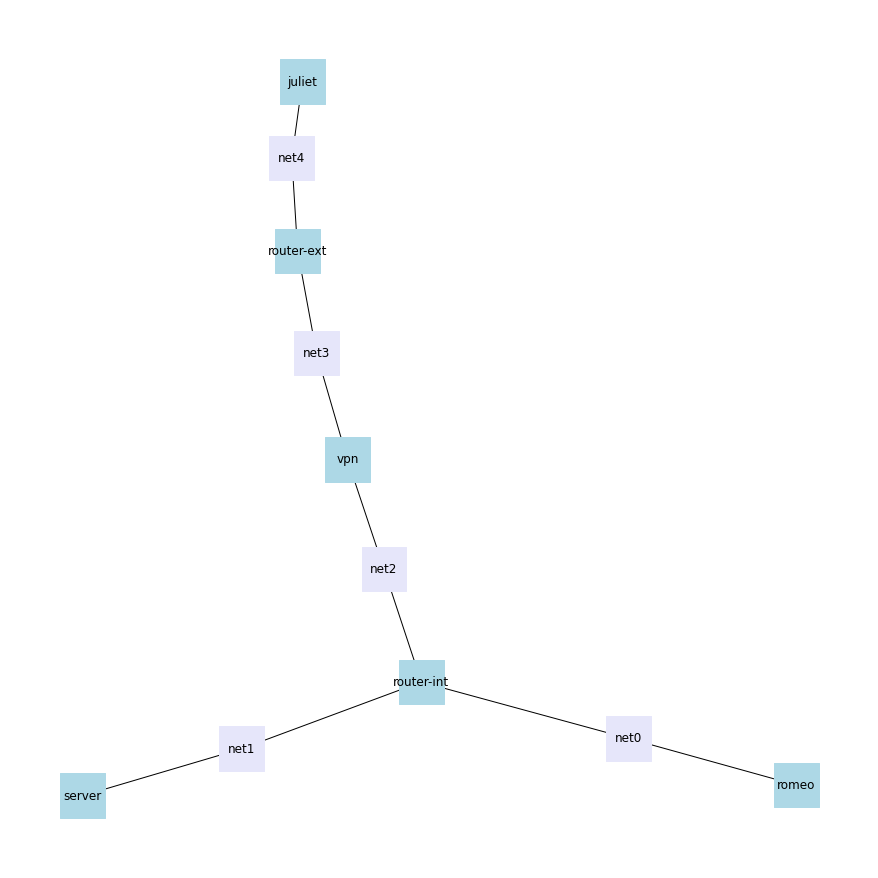

In [74]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
plt.figure(figsize=(12,12)) # or some other size 
nx.draw(G, node_size=2000, node_shape='s', node_color=[n[1]['color'] for n in nodes], with_labels=True)

### Exercise: Log in to resources
Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the nodes in your topology.

In [54]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
ssh_str = 'ssh -i ' + slice.get_slice_private_key_file() + \
    ' -J ' + fablib.get_bastion_username() + '@' + fablib.get_bastion_public_addr() + \
    ' -F /home/fabric/work/fabric_config/ssh_config '
slice_info = [{'Name': n.get_name(), 'SSH command': ssh_str + n.get_username() + '@' + str(n.get_management_ip())} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
romeo,ssh -i /home/fabric/work/fabric_config/slice_key -J cy2478_0000088631@bastion.fabric-testbed.net -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fec9:f089
juliet,ssh -i /home/fabric/work/fabric_config/slice_key -J cy2478_0000088631@bastion.fabric-testbed.net -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fe07:5c6
server,ssh -i /home/fabric/work/fabric_config/slice_key -J cy2478_0000088631@bastion.fabric-testbed.net -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fedd:770a
router-int,ssh -i /home/fabric/work/fabric_config/slice_key -J cy2478_0000088631@bastion.fabric-testbed.net -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:feaf:585a
router-ext,ssh -i /home/fabric/work/fabric_config/slice_key -J cy2478_0000088631@bastion.fabric-testbed.net -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fe47:bd50
vpn,ssh -i /home/fabric/work/fabric_config/slice_key -J cy2478_0000088631@bastion.fabric-testbed.net -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:c80:1001:f816:3eff:fed6:b600


Now, you can open an SSH session on any of the nodes as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each host and the router. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

Now you can continue to perform the Network Layer Security experiments on these host sessions.

### Exercise: Transfer .pcap files from a FABRIC host


Now, retrieve the `vpn-router-int.pcap` and `vpn-router-ext.pcap` files from router-int and router-ext using the following commands:

In [65]:
host_name = "router-int"
slice.get_node(host_name).download_file("/home/fabric/work/vpn-%s.pcap" % host_name, "/home/ubuntu/vpn-%s.pcap" % host_name)

In [66]:
host_name = "router-ext"
slice.get_node(host_name).download_file("/home/fabric/work/vpn-%s.pcap" % host_name, "/home/ubuntu/vpn-%s.pcap" % host_name)

Then in the Jupyter environment, click on the folder icon in the file browser on the left to make sure that you are located in your “Jupyter home” directory.

Then, you should see the above .pcap files appear in the Jupyter file browser on the left. You can now download this file from the Jupyter environment to your own laptop to analyze them in Wireshark.

### Delete your slice resources

If you finished your experiment early, you should delete your slice! The following cell deletes all the resources in your slice, freeing them for other experimenters.

In [39]:
slice.delete()

In [ ]:
slice.show()